In [61]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import os
import scipy
import scipy.io as io
from PIL import Image
from skimage.transform import resize
from skimage.transform import rescale, resize, downscale_local_mean


In [37]:
vortall_mat = io.loadmat(os.path.join('.','DATA','VORTALL.mat'))
X = vortall_mat['VORTALL']

In [38]:
X.shape


(89351, 151)

In [174]:
def plotFlow(X):    
    ## Plot Mode 2
    vortmin = -5
    vortmax = 5
    V2 = np.copy(np.real(np.reshape(X,(449,199))))
    V2 = V2.T

    # normalize values... not symmetric
    minval = np.min(V2)
    maxval = np.max(V2)

    if np.abs(minval) < 5 and np.abs(maxval) < 5:
        if np.abs(minval) > np.abs(maxval):
            vortmax = maxval
            vortmin = -maxval
        else:
            vortmin = minval
            vortmax = -minval

    V2[V2 > vortmax] = vortmax
    V2[V2 < vortmin] = vortmin

    plt.imshow(V2,cmap='jet',vmin=vortmin,vmax=vortmax)

    cvals = np.array([-4,-2,-1,-0.5,-0.25,-0.155])
    plt.contour(V2,cvals*vortmax/5,colors='k',linestyles='dashed',linewidths=1)
    plt.contour(V2,np.flip(-cvals)*vortmax/5,colors='k',linestyles='solid',linewidths=0.4)

    plt.scatter(49,99,5000,color='k') # draw cylinder

    #plt.show()

In [194]:
# coarsen images by factor of 20

n = 449 
m = 199
nn = int(449/20)
print(nn)
mm = int(m/20)
print(mm)
size = [nn, mm]

22
9


In [162]:
mmm = nn*mm
M = X.shape[1]

Theta = np.zeros((mmm, M ))
for k in range(M):
    temp = np.reshape(np.copy(X[:,k]), (n,m))
    tempSmall = resize(temp, size, anti_aliasing=True)
    Theta[:,k] = np.reshape(tempSmall, mmm )

In [163]:
## Renormalize Columns of Theta
normTheta = np.zeros(M)
for k in range(M):
    normTheta[k] = np.linalg.norm(Theta[:,k])
    Theta[:,k] = Theta[:,k]/normTheta[k]


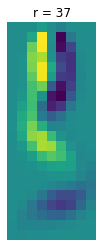

KeyboardInterrupt: 

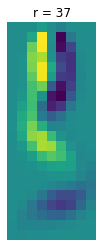

In [146]:
%matplotlib inline
import time
import pylab as pl
from IPython import display

for i in range(50):
    M = np.reshape(Theta[:,i], size)
    plt.title('r = ' + str(i))
    plt.imshow(M)
    plt.axis('off')
    display.clear_output(wait=True)
    display.display(pl.gcf())
    time.sleep(1.0)

In [166]:
#!pip install imageio
import imageio
def createMovie(X):
    plt.rcParams['figure.figsize'] = [8, 8]
    filenames = []
    for i in range(150):
        plotFlow1(X[:,i])
        filename = './pics/full'+str(i)+'.png'
        filenames.append(filename)
        plt.savefig(filename)
        plt.close()
    with imageio.get_writer('vortices.gif', mode='I') as writer:
        for filename in filenames:
            image = imageio.v2.imread(filename)
            writer.append_data(image)
    for filename in set(filenames):
        os.remove(filename)

(22, 9)


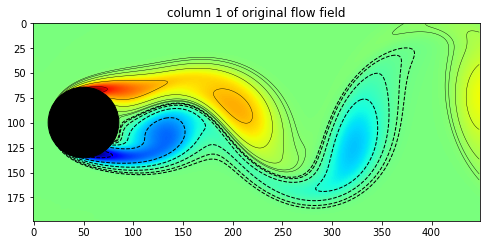

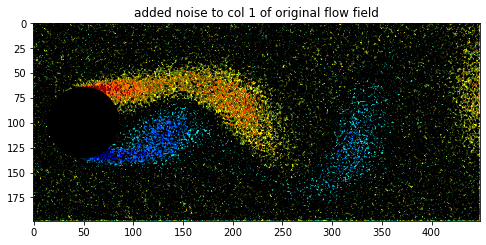

In [183]:
x1 = np.copy(X[:, 1])
noisyImage = np.copy(x1) + 1*np.random.randn(*x1.shape)
plt.figure()
plotFlow(x1)
plt.title('column 1 of original flow field')

plt.figure()
plotFlow(noisyImage)
plt.title('added noise to col 1 of original flow field')

tempp = np.reshape(np.copy(noisyImage), (n,m))
temppSmall = resize(tempp, size, anti_aliasing=False)
print(temppSmall.shape)
TestImage= np.reshape(temppSmall, mmm )

In [196]:
# downsample noise field
t =22*9
print(x1.shape)
size_y = (np.array([449,199])*(1/20)).astype(int)
size_y
temp_y = np.reshape(np.copy(noisyImage), (449,199))
temp_noisy = resize(temp_y, size_y, anti_aliasing=True)
print(temp_noisy.shape)
TestImage= np.reshape(temp_noisy, t )

(89351,)
(22, 9)


In [181]:
size_y

array([4467])

In [152]:
# L1 Minimum norm solution s_L1
def L1_norm(x):
    return np.linalg.norm(x,ord=1)

from scipy.optimize import minimize


#### Get sparse vector s by (inverse the downsampled X )* ( down sampled noisy TestImage)

In [206]:

eps = 10
T = np.copy(TestImage)
constr = ({'type': 'ineq', 'fun': lambda x:  eps - np.linalg.norm(Theta @ x - TestImage,2)})

x0 = np.linalg.pinv(Theta) @ T
res = minimize(L1_norm, x0, method = 'SLSQP', constraints = constr)
s = res.x
print(s.shape)

(151,)


#### Find the column from X that is most similar to the selected noisy Testimage data

(198, 1)
(198, 1)
2


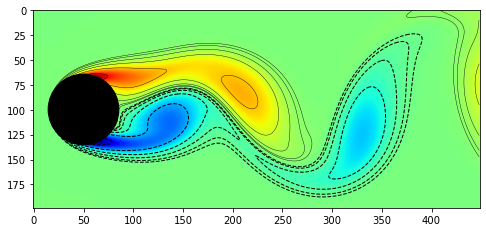

In [217]:
err = np.zeros(151)
for k in range(151):
    L = range(k, (k+1))
    print(Theta[:,L].shape)
    err[k] = np.linalg.norm(noisyImage - X[:,L] @ (s[L]/normTheta[L]))/np.linalg.norm(noisyImage)
Err = err.tolist()
Index = Err.index(min(Err))
print(Index)
plotFlow(X[:, Index])